In [1]:
import sys
import os
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
# add RealSeries/realseries to sys path for import realseries
sys.path.append('..')
from realseries.models.srcnn import SR_CNN
from realseries.utils.evaluation import point_metrics, adjust_predicts
from realseries.utils.data import load_Yahoo, load_NAB
from realseries.utils.visualize import plot_anom, plot_mne

In [2]:
warnings.filterwarnings("ignore")
os.environ["CUDA_VISIBLE_DEVICES"] = '5'

load data from /mnt/mfs/zhangxianrui/code/RealSeries/examples/data/NAB_data/realKnownCause/nyc_taxi.csv


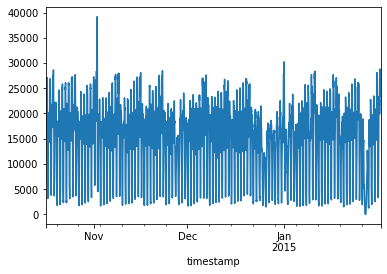

In [3]:
# load and split data
# ----------------------------
dirname = 'realKnownCause'
filename = 'nyc_taxi.csv'

# the fraction of used for test
fraction=0.5

train_set, test_set = load_NAB(dirname, filename, fraction=fraction)
# the last column is label; other columns are values
train_data,train_label = train_set.iloc[:, 0],train_set.iloc[:, -1]
test_data,test_label = test_set.iloc[:, 0],test_set.iloc[:, -1]
test_data.plot()

Creating RawArray with float64 data, n_channels=2, n_times=5160
    Range : 0 ... 5159 =      0.000 ...  5159.000 secs
Ready.


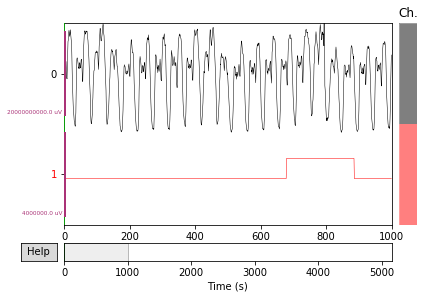

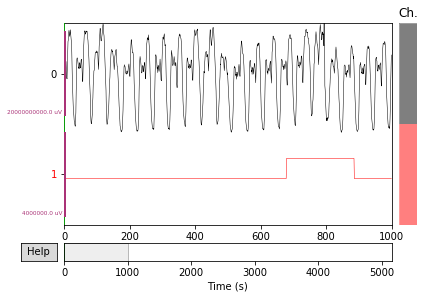

In [4]:
scalings = {'eeg': 1e4, 'ecg': 2}
color=dict(eeg='k', ecg='r')
ch_types=['eeg','ecg']

plot_mne(test_set,
        scalings=scalings,
        ch_types=ch_types,
        color=color)

In [5]:
# srcnn parameters
# --------------------
model_path = Path('../snapshot/sr/', filename[:-4])
print(f'srcnn model path: {model_path}')

# window size
window=50

# learning rate
lr=1e-5

# random seed
seed=0

# number of total training epochs
epochs=30

# the size of each batch
batch_size=64

# dropout_rate
dropout_rate=0.5

# step szie when the window sliding on the input sequence
step = 1

# the number of anomaly point added the input window
num = 10

srcnn model path: ../snapshot/sr/nyc_taxi


loading ../snapshot/sr/nyc_taxi/30.pt
scores.shape:(5160,),X.shape:(5160,) [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
***********************************************
precision:0.9999999833333336, recall:0.005797101448715256, f1:0.011527376373305524, tp:6, tn:4125, fp:0, fn:1029


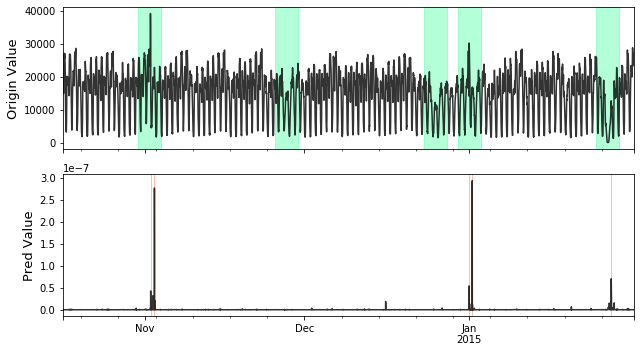

In [6]:
#build srcnn model
sr_cnn = SR_CNN(model_path,
                window=window,
                lr=lr,
                seed=seed,
                epochs=epochs,
                batch_size=batch_size,
                dropout=dropout_rate)

# train the model
# sr_cnn.fit(train_data,step=step,num=num)

# get anomaly score
score = sr_cnn.detect(test_data,test_label,step=1)

# the score above the thres_percent% is anomaly, and label is assigned to True
thres_percent=99.9
thres = np.percentile(score,thres_percent)
pred_label = (score>thres)

# visualization
plot_anom(
    test_set,
    pred_label,
    score)

# calc metrics
precision, recall, f1, tp, tn, fp, fn = point_metrics(pred_label,test_label)
print('precision:{}, recall:{}, f1:{}, tp:{}, tn:{}, fp:{}, fn:{}'.format(precision, recall, f1, tp, tn, fp, fn))

precision:0.9999999998389695, recall:0.5999999999420289, f1:0.7499999530344232, tp:621, tn:4125, fp:0, fn:414


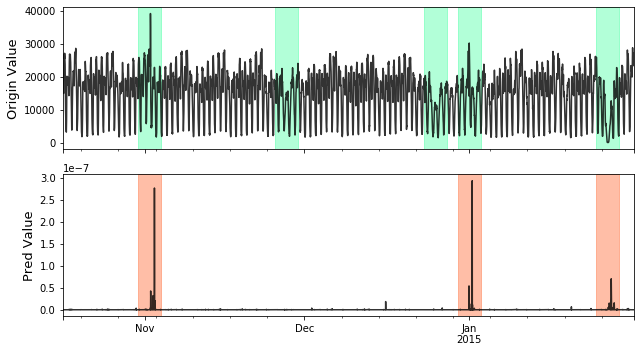

In [7]:
# adjust the pred_label for better visualization
adjust_pred_label = adjust_predicts(pred_label,test_label,delay=200)
plot_anom(
    test_set,
    adjust_pred_label,
    score)
precision, recall, f1, tp, tn, fp, fn = point_metrics(adjust_pred_label,test_label)
print('precision:{}, recall:{}, f1:{}, tp:{}, tn:{}, fp:{}, fn:{}'.format(precision, recall, f1, tp, tn, fp, fn))

load data from /mnt/mfs/zhangxianrui/code/RealSeries/examples/data/Yahoo_data/A2Benchmark/synthetic_3.csv
split_rate: 0.5


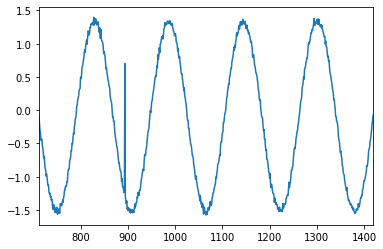

In [8]:
# dirname
dirname = 'A2Benchmark'
filename = 'synthetic_3.csv'

# load and split dataset
train_set, test_set = load_Yahoo(dirname, filename, use_norm=True)
train_set, test_set = train_set[['value','anomaly']], test_set[['value','anomaly']]

# the last column is label; other columns are values
train_data,train_label = train_set.iloc[:, 0],train_set.iloc[:, -1]
test_data,test_label = test_set.iloc[:, 0],test_set.iloc[:, -1]
test_data.plot()

In [9]:
# srcnn parameters
# -------------------------
# the dir for saving and loding trained model
model_path = Path('../snapshot/sr/', filename[:-4])
print(f'srcnn model path: {model_path}')

# window szie
window=30

# epochs
epochs=20

# dropout_rate
dropout_rate=0.3

# step szie when the window sliding on the input sequence
step = 3

# the number of anomaly point added the input window
num = 5

#build model
sr_cnn = SR_CNN(model_path,
                window=window,
                lr=lr,
                seed=seed,
                epochs=epochs,
                batch_size=batch_size,
                dropout=dropout_rate)
sr_cnn.fit(train_data,step=step,num=num)

score = sr_cnn.detect(test_data,test_label)
print(score.shape)

srcnn model path: ../snapshot/sr/synthetic_3
generating train data


  0%|          | 0/4 [00:00<?, ?it/s]

fake data size: (227, 2, 30)
CNN(
  (layer1): Conv1d(30, 30, kernel_size=(1,), stride=(1,))
  (dropout1): Dropout(p=0.3, inplace=False)
  (layer2): Conv1d(30, 60, kernel_size=(1,), stride=(1,))
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=60, out_features=120, bias=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=120, out_features=30, bias=True)
  (relu): ReLU(inplace=True)
)
length : 227


  0%|          | 0/4 [00:00<?, ?it/s]

Train Epoch: 1 [0/227 (0%)]	Loss: 22.013481
Train Epoch: 2 [0/227 (0%)]	Loss: 15.563115


  0%|          | 0/4 [00:00<?, ?it/s]

Train Epoch: 3 [0/227 (0%)]	Loss: 10.801620
Train Epoch: 4 [0/227 (0%)]	Loss: 6.587691


  0%|          | 0/4 [00:00<?, ?it/s]

Train Epoch: 5 [0/227 (0%)]	Loss: 3.998566
Train Epoch: 6 [0/227 (0%)]	Loss: 1.453823


  0%|          | 0/4 [00:00<?, ?it/s]

Train Epoch: 7 [0/227 (0%)]	Loss: 0.600434
Train Epoch: 8 [0/227 (0%)]	Loss: 0.171560


100%|██████████| 4/4 [00:00<00:00, 40.39it/s]

Train Epoch: 9 [0/227 (0%)]	Loss: 0.179115
Train Epoch: 10 [0/227 (0%)]	Loss: 0.063634
saving ../snapshot/sr/synthetic_3/10.pt



  0%|          | 0/4 [00:00<?, ?it/s]

Train Epoch: 11 [0/227 (0%)]	Loss: 0.057937
Train Epoch: 12 [0/227 (0%)]	Loss: 0.093411


  0%|          | 0/4 [00:00<?, ?it/s]

Train Epoch: 13 [0/227 (0%)]	Loss: 0.081870
Train Epoch: 14 [0/227 (0%)]	Loss: 0.027902


  0%|          | 0/4 [00:00<?, ?it/s]

Train Epoch: 15 [0/227 (0%)]	Loss: 0.108445
Train Epoch: 16 [0/227 (0%)]	Loss: 0.046013


100%|██████████| 4/4 [00:00<00:00, 36.75it/s]

Train Epoch: 17 [0/227 (0%)]	Loss: 0.086010
Train Epoch: 18 [0/227 (0%)]	Loss: 0.040382


100%|██████████| 4/4 [00:00<00:00, 35.23it/s]

Train Epoch: 19 [0/227 (0%)]	Loss: 0.035419
Train Epoch: 20 [0/227 (0%)]	Loss: 0.029001
saving ../snapshot/sr/synthetic_3/20.pt


loading ../snapshot/sr/synthetic_3/20.pt
scores.shape:(711,),X.shape:(711,) [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
***********************************************
(711,)


precision:0.0, recall:0.0, f1:0.0, tp:0, tn:709, fp:1, fn:1


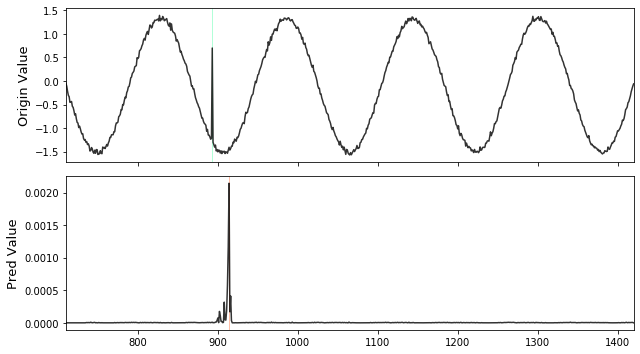

In [10]:
# thres
thres_percent=99.9
thres = np.percentile(score,thres_percent)
pred_label = (score>thres)

# plot
plot_anom(
    test_set,
    pred_label,
    score)
precision, recall, f1, tp, tn, fp, fn = point_metrics(pred_label,test_label)
print('precision:{}, recall:{}, f1:{}, tp:{}, tn:{}, fp:{}, fn:{}'.format(precision, recall, f1, tp, tn, fp, fn))